# **NYC Air Quality Predictive Modeling**


NYC Air Quality

## NYC Air Quality:
The air quality data we are looking at contains hourly PM2.5 measurements across 25 stations over 2024. PM2.5 refers to particulate matter with a diameter of $2.5\mu m$ (micrometers) or less, which poses significant health risks due to its ability to penetrate deep into the lungs and enter the bloodstream. 

In [2]:
# Imports
import pandas as pd
import numpy as np
import glob
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### Data Cleaning 

In [3]:
def combine_and_clean_data(folder_path, threshold, lags=4):

    # grab files
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

    # combine into df
    df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

    # change time and site variables for analysis
    df['ObservationTimeUTC'] = pd.to_datetime(df['ObservationTimeUTC'], errors='coerce')

    # grab labels and add them with merge
    labels = pd.read_csv("data/AQ_2024/labels.csv")
    df = df.merge(labels, on="SiteID", how="left")
    df = df.drop(columns=['SiteName_x'])
    df = df.drop(columns=['SiteID'])
    df = df.rename(columns={'SiteName_y': 'SiteName'})
    df = df.dropna()

    # build lag features + target T/F
    def add_lags_and_target(g):
        for i in range(1, lags):
            g[f'lag_{i}'] = g['Value'].shift(i)
        g['target'] = (g['Value'] > threshold).astype('Int64')
        return g

    df = df.groupby('SiteName', group_keys=False).apply(add_lags_and_target)

    # drop incomplete rows
    lag_cols = [f'lag_{i}' for i in range(1, lags)]
    df = df.dropna(subset=lag_cols + ['target'])

    # stats across all lag columns
    df['lag_mean']   = df[lag_cols].mean(axis=1)
    df['lag_std']    = df[lag_cols].std(axis=1)
    df['lag_median'] = df[lag_cols].median(axis=1)

    return df

In [4]:
def temporal_train_test_split(df, test_size=0.2, time_col='ObservationTimeUTC'):
    """
    Split by time: the earliest (1 - test_size) fraction is train, the latest fraction is test.
    This prevents leakage from future into past.
    """
    df = df.sort_values(time_col).reset_index(drop=True)
    cutoff_idx = int(len(df) * (1 - test_size))
    train_df = df.iloc[:cutoff_idx].copy()
    test_df  = df.iloc[cutoff_idx:].copy()
    return train_df, test_df

def build_rf_pipeline(cat_col='SiteName', lag_cols=None, n_estimators=400, random_state=42, lags=4):
    # If lag_cols not given, create lag_1..lag_l
    if lag_cols is None:
        lag_cols = [f'lag_{i}' for i in range(1, lags + 1)]

    numeric_features = lag_cols
    categorical_features = [cat_col]

    preproc = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        class_weight="balanced",
        random_state=random_state
    )

    model = Pipeline(steps=[("prep", preproc), ("rf", rf)])
    return model, numeric_features, categorical_features

def build_log_pipeline(cat_col='SiteName', lag_cols=None, random_state=42, lags=4):
    # If lag_cols not given, create lag_1..lag_l
    if lag_cols is None:
        lag_cols = [f'lag_{i}' for i in range(1, lags + 1)]

    numeric_features = lag_cols
    categorical_features = [cat_col]

    preprocess = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("num", StandardScaler(), numeric_features)
        ],
        remainder="drop"
    )

    log_reg = LogisticRegression(
        max_iter=500,
        class_weight='balanced',   # good for imbalanced data
        solver='lbfgs'
    )

    model = Pipeline(steps=[
        ("prep", preprocess),
        ("log_reg", log_reg)
    ])
    
    return model

def train_and_evaluate(df, model_type="rf", test_size=0.2, threshold=0.5, roc=False, lags=4):
    """
    df must contain columns: 
      'ObservationTimeUTC', 'SiteName', lag_1..lag_k, 'target'
    """
    # 1) temporal split
    train_df, test_df = temporal_train_test_split(
        df, test_size=test_size, time_col='ObservationTimeUTC'
    )

    # features = all lag_* columns + SiteName
    lag_cols = [c for c in df.columns if c.startswith("lag_")]
    feature_cols = ['SiteName'] + lag_cols
    X_train = train_df[feature_cols]
    y_train = train_df['target']
    X_test  = test_df[feature_cols]
    y_test  = test_df['target']

    # 2) build model
    if model_type == "log":
        model = build_log_pipeline(cat_col='SiteName', lag_cols=lag_cols, lags=lags)
        model_name = "Logistic Regression"
    else:
        model, _, _ = build_rf_pipeline(cat_col='SiteName', lag_cols=lag_cols, lags=lags)
        model_name = "Random Forest"
    
    # 3) fit
    model.fit(X_train, y_train)

    # 4) probabilities and predictions
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    
    # 5) ROC curve
    if roc:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({model_name})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 6) metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # 7) print results
    print(f"=== {model_name} (time-aware split) ===")
    print(f"Threshold used for target: {threshold}")
    print(f"Train size: {len(train_df):,}  |  Test size: {len(test_df):,}")
    print(f"Accuracy : {acc:0.4f}")
    print(f"Precision: {prec:0.4f}")
    print(f"Recall   : {rec:0.4f}")
    print(f"F1-score : {f1:0.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report")
    print(classification_report(y_test, y_pred, digits=4))

    return model, (X_train, y_train, X_test, y_test)


In [32]:
folder_path = "data/AQ_2024"

# PM 2.5 value we want to predict on
threshold = 12

# number of past values in looks at + 1
# if we want to look at past 3 values num_lags=4
num_lags = 6
df = combine_and_clean_data(folder_path, threshold, num_lags)

df.shape
df.head()
df.describe()
df["SiteName"].describe()

C:\Users\edcro\AppData\Local\Temp\ipykernel_16372\3229207491.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('SiteName', group_keys=False).apply(add_lags_and_target)


count                80128
unique                  14
top       Broadway/35th St
freq                  8717
Name: SiteName, dtype: object

## Air Quality Classification Model 1: Random Forest

In [27]:
model, data_splits = train_and_evaluate(df, test_size=0.5, threshold=0.5)

=== Random Forest (time-aware split) ===
Threshold used for target: 0.5
Train size: 40,064  |  Test size: 40,064
Accuracy : 0.9650
Precision: 0.8342
Recall   : 0.8176
F1-score : 0.8258
Confusion Matrix:
[[35336   661]
 [  742  3325]]

Classification Report
              precision    recall  f1-score   support

         0.0     0.9794    0.9816    0.9805     35997
         1.0     0.8342    0.8176    0.8258      4067

    accuracy                         0.9650     40064
   macro avg     0.9068    0.8996    0.9032     40064
weighted avg     0.9647    0.9650    0.9648     40064



In [28]:
import joblib

joblib.dump(model, "./air_quality_rf.joblib")

['./air_quality_rf.joblib']

## Air Quality Classification Model 2: Logistic Classification

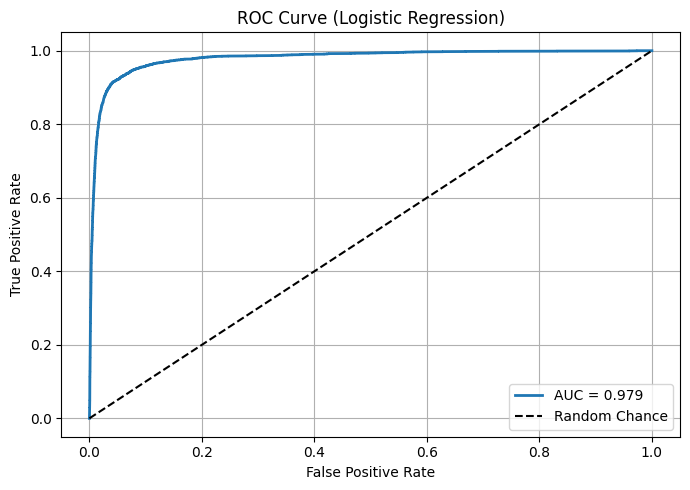

=== Logistic Regression (time-aware split) ===
Threshold used for target: 0.6
Train size: 40,064  |  Test size: 40,064
Accuracy : 0.9618
Precision: 0.7718
Recall   : 0.8849
F1-score : 0.8245
Confusion Matrix:
[[34933  1064]
 [  468  3599]]

Classification Report
              precision    recall  f1-score   support

         0.0     0.9868    0.9704    0.9785     35997
         1.0     0.7718    0.8849    0.8245      4067

    accuracy                         0.9618     40064
   macro avg     0.8793    0.9277    0.9015     40064
weighted avg     0.9650    0.9618    0.9629     40064



In [31]:
model, data_splits = train_and_evaluate(df, model_type="log", test_size=0.5, threshold=0.6, roc=True, lags=num_lags)